In [19]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import root_scalar
# plt.style.use("ggplot")
plt.rcParams['font.family'] = "serif"
plt.rc('text', usetex=True)

# Konstrukcija profila cevi

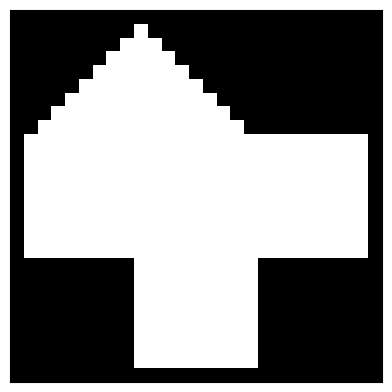

In [20]:
def get_u(j,k,n):
    """Returns the initial u_{j,k}.

    First we check where on the grid we are:
    (0,0) | (1,0) | (2,0)
    (0,1) | (1,1) | (2,1)
    (0,2) | (1,2) | (2,2)

    """
    assert n%3 == 0, "Number of points must be divisible by 3."
    n1 = n / 3 - 1
    n2 = 2 * n / 3 - 1

    col = 3 * j//n
    row = 3 * k//n

    squares = {
        (2,0) : 0,
        (2,2) : 0,
        (0,2) : 0,
        (1,1) : 1,
        (1,2) : 1,
        (2,1) : 1,
        (0,1) : 1
    }
    try:
        return squares[(col, row)]
    except KeyError:
        if col==0:
            if j+k-2 < n1:
                return 0
            return 1
        if col==1:
            if j > k + n1:
                return 0
            return 1
n = 27

def get_hiska(n):
    u0 = np.empty((n,n), dtype=float)
    for j in range(n):
        for k in range(n):
             u0[k, j] = get_u(j,k,n)
    u0[:, 0] = u0[0,:] = u0[:, n-1] = u0[n-1, :] = 0
    return u0
u0 = get_hiska(n)
plt.matshow(u0, cmap="gray")
plt.xticks([])
plt.yticks([])


plt.savefig("1-hiska.pdf")
plt.show()
u_hiska = u0.copy()

# Implementacija Jacobijeve metode 

Zaenkrat delam brezdimenzijsko in se ne sekiram z velikostjo dx in dy.

<Figure size 400x300 with 0 Axes>

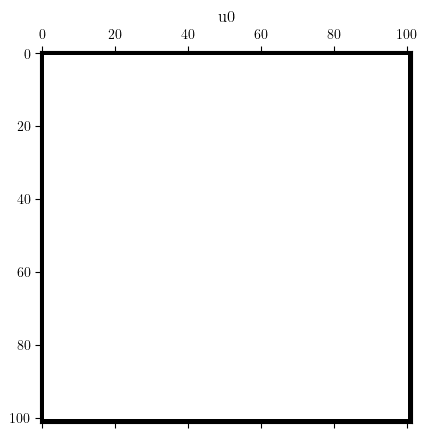

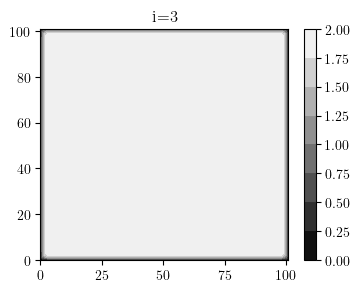

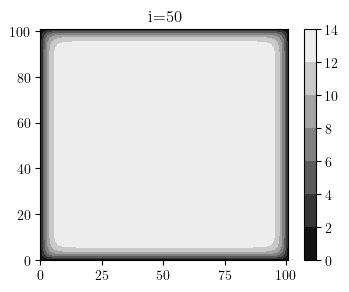

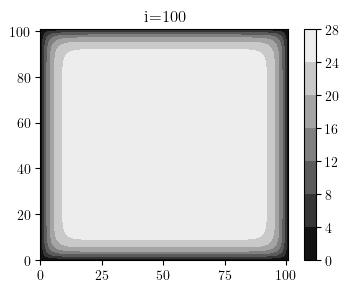

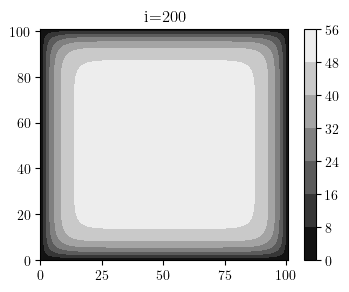

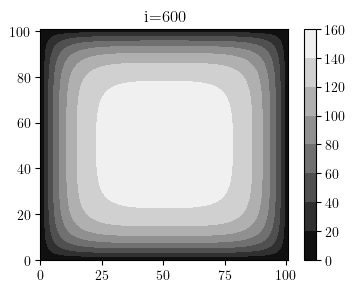

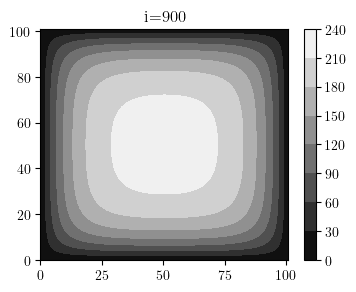

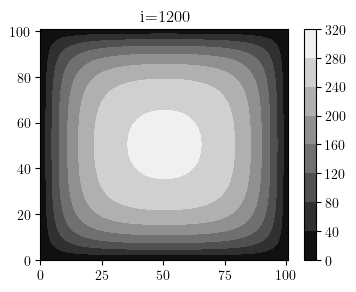

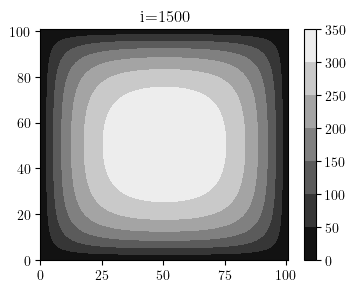

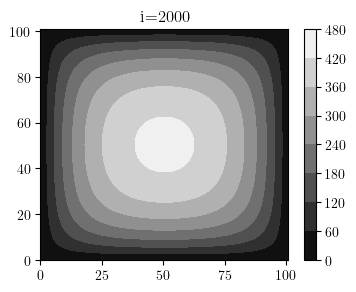

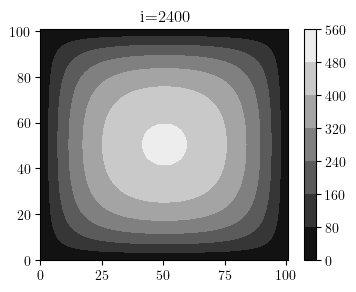

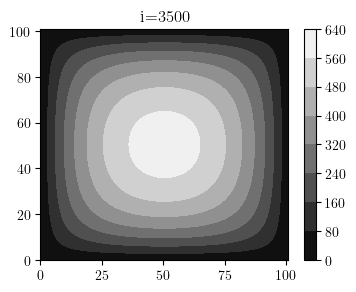

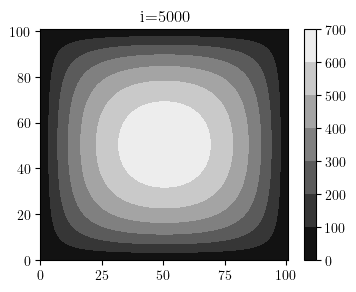

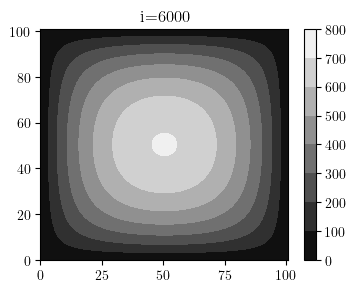

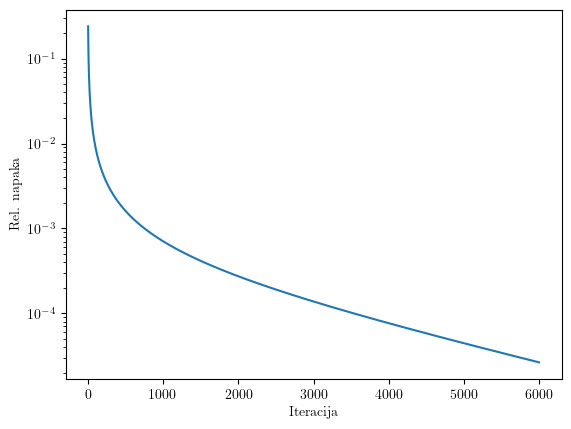

In [21]:
n = 102
u0 = np.full((n, n), 1, dtype=float)
u0[0, :] = u0[n-1, :] =u0[:, n-1] = u0[:, 0] = 0

plt.figure(figsize=(4,3))
plt.matshow(u0, cmap="gray")
plt.title("u0")
plt.show()


def iterstep(u, Q):
    n = u.shape[0]
    u_new = u.copy()
    for y in range(1,n-1):
        for x in range(1,n-1):
            u_new[x,y] = 1/4 * (Q[x,y] + u[x+1, y] + u[x-1, y] + u[x, y+1] + u[x, y-1])
    return u_new

def rel_err(a1, a2):

    return np.sum(np.abs(a1.reshape(-1)-a2.reshape(-1)))/np.sum(np.abs(a1.reshape(-1)))

Q = u0.copy()
u_current = u0.copy()
N_iters = 6000
iters = np.array([i for i in range(N_iters + 1)  ])
rel_errors = np.empty_like(iters, dtype=float)
for i in iters:
    u_new = iterstep(u_current, Q)
    rel_errors[i] = rel_err(u_current, u_new)
    if i in {3, 50, 100, 200, 600, 900, 1200, 1500,2000, 2400,3500, 5000, 6000}:
        plt.figure(figsize=(4,3))
        plt.contourf(u_new, cmap="gray")
        c = plt.colorbar()
        plt.title(f"i={i}")
        plt.savefig(f"0-kvadratna_i{i}.pdf")
        plt.show()
    u_current = u_new
plt.plot(iters, rel_errors)
plt.semilogy()
plt.ylabel("Rel. napaka")
plt.xlabel("Iteracija")
plt.savefig("0-errors.pdf")
plt.show()


<Figure size 400x300 with 0 Axes>

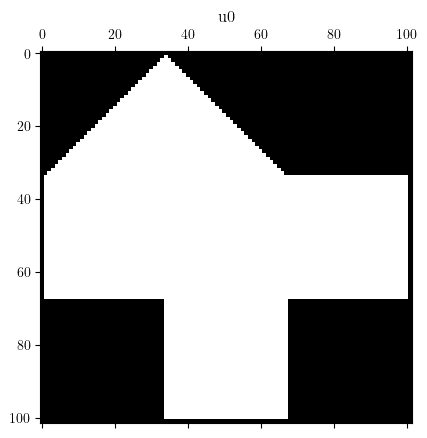

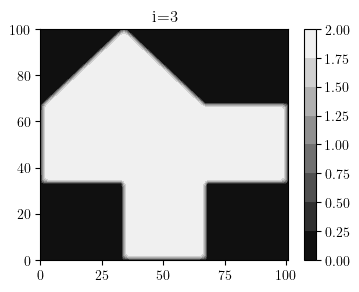

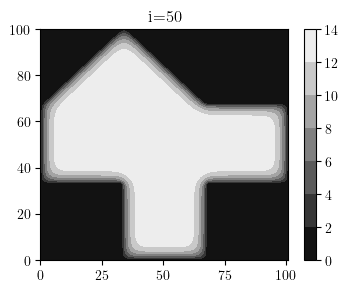

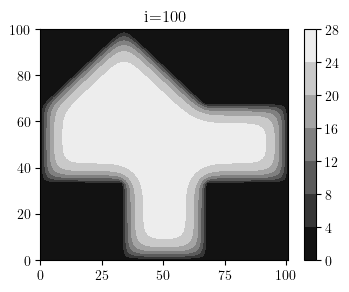

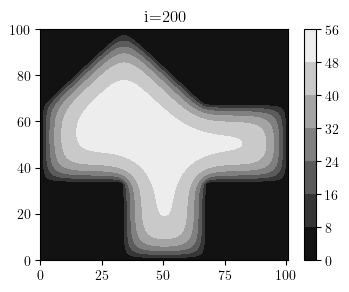

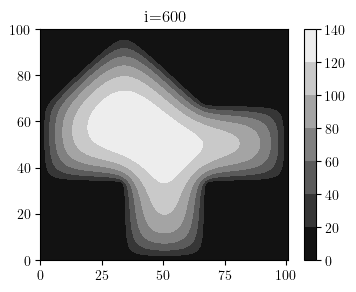

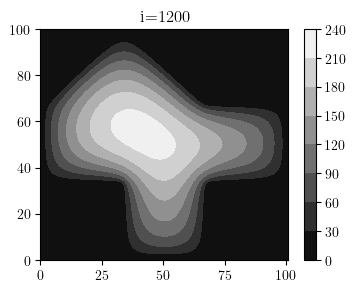

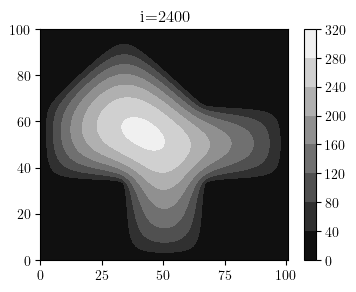

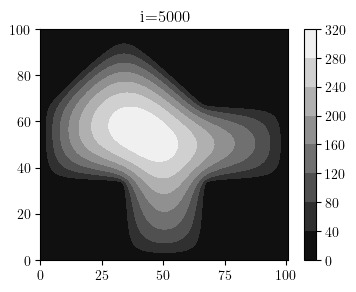

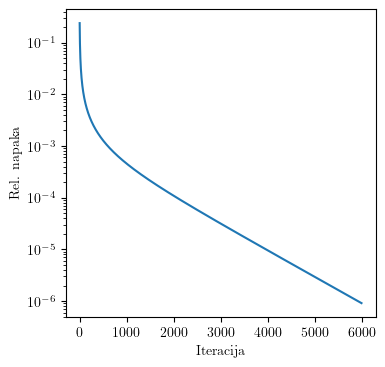

In [22]:
n = 102
u0 = get_hiska(n)

plt.figure(figsize=(4,3))
plt.matshow(u0, cmap="gray")
plt.title("u0")
plt.show()


def iterstep(u, Q, u0):
    n = u.shape[0]
    u_new = u.copy() * u0
    for y in range(1,n-1):
        for x in range(1,n-1):
            u_new[x,y] = 1/4 * (Q[x,y] + u[x+1, y] + u[x-1, y] + u[x, y+1] + u[x, y-1])
    return u_new * u0

def rel_err(a1, a2):
    return np.sum(np.abs(a1.reshape(-1)-a2.reshape(-1)))/np.sum(np.abs(a1.reshape(-1)))


Q = u0.copy()
u_current = u0.copy()
N_iters = 6000
iters = np.array([i for i in range(N_iters)])
rel_errors = np.empty_like(iters, dtype=float)
for i in iters:
    u_new = iterstep(u_current, Q, u0)
    rel_errors[i] = rel_err(u_current, u_new)
    if i in {3, 50, 100, 200, 600, 1200, 2400, 5000}:
        plt.figure(figsize=(4,3))
        plt.contourf(u_new[-1:0:-1, :], cmap="gray")
        c = plt.colorbar()
        plt.title(f"i={i}")
        plt.savefig(f"1-hiska_i{i}.pdf")
        plt.show()
    u_current = u_new
plt.figure(figsize=(4,4))
plt.plot(iters, rel_errors)
plt.semilogy()
plt.ylabel("Rel. napaka")
plt.xlabel("Iteracija")
plt.savefig("1-errors.pdf")
plt.show()


In [23]:
import numpy
def rel_err(a1: numpy.ndarray, a2: numpy.ndarray) -> float:

    return np.sum(np.abs(a1-a2).reshape(-1))/np.sum(np.abs(a1.reshape(-1)))
rel_err(u0, u_new)

140.8379038600261

# SOR implementacija

In [24]:

def rel_err(a1, a2):
    return np.sum(np.abs(a1.reshape(-1)-a2.reshape(-1)))#/np.sum(np.abs(a1.reshape(-1)))

def iterstep(u, Q, omega=1):
    n = u.shape[0]
    u_new = u.copy() * Q
    u_star = u_new.copy()
    for y in range(1,n-1):
        for x in range(1,n-1):
            u_star[x,y] = (1/4 * (Q[x,y] + u[x+1, y] + u_new[x-1, y] + u[x, y+1] + u_new[x, y-1])) * Q[x,y]
            u_new[x,y] = (u[x,y] + omega * (u_star[x,y]-u[x,y])) * Q[x,y]

    #u_new =  u_new * Q
    return u_new

def make_final_version(n):
    u0 = Q = u_new = get_hiska(n)
    for i in range(50*n):
        u_new = iterstep(u_new, Q, omega=1)
    return u_new



In [25]:
n = 102
u_final = make_final_version(n)

omegas = np.linspace(0.5, 2, 100)
diff = np.empty_like(omegas)


def evaluate(omega, n_iter=100):
    u0 = Q = u_new = get_hiska(n)
    for i in range(n_iter):
        u_new = iterstep(u_new, Q, omega=omega)
    return rel_err(u_new, u_final)
for i, omega in enumerate(omegas):
    diff[i] = evaluate(omega)

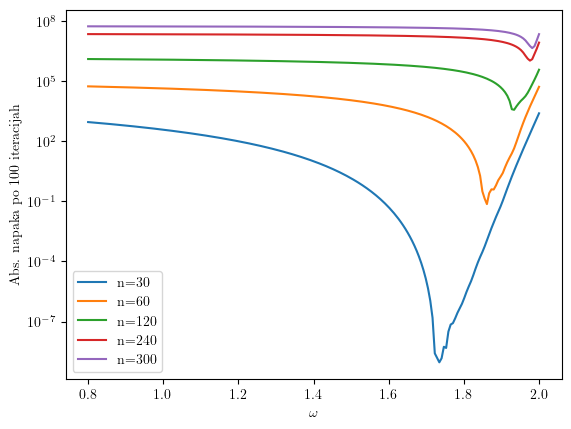

In [26]:
omegas = np.linspace(0.8, 2, 200)
diff = np.empty_like(omegas)

def evaluate(omega, n_iter=100, n=30, u_final=None):
    u0 = Q = u_new = get_hiska(n)
    for i in range(n_iter):
        u_new = iterstep(u_new, Q, omega=omega)
    return rel_err(u_new, u_final)

for n in [30, 60, 120, 240, 300]:
    u_final = make_final_version(n)
    for i, omega in enumerate(omegas):
        print(n, i, end="\r")
        diff[i] = evaluate(omega, n=n, u_final = u_final)
    plt.plot(omegas, diff, label=f"n={n}")

plt.legend()
plt.semilogy()
plt.ylabel("Abs. napaka po 100 iteracijah")
plt.xlabel("$\omega$")
plt.savefig("1-omegas.pdf")
plt.show()

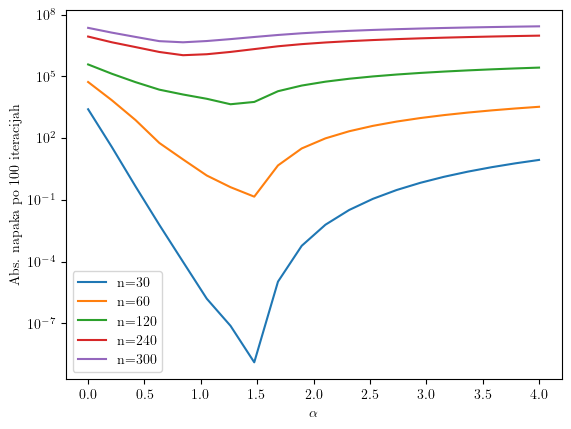

In [27]:
aa = np.linspace(0, 4, 20)
diff = np.empty_like(aa)

def evaluate(omega, n_iter=100, n=102, u_final=None):
    u0 = Q = u_new = get_hiska(n)
    for i in range(n_iter):
        u_new = iterstep(u_new, Q, omega=omega)
    return rel_err(u_new, u_final)

for n in [30, 60, 120, 240, 300]:
    u_final = make_final_version(n)
    for i, a in enumerate(aa):
        print(n, i, end="\r")
        omega = 2/(1+a * np.pi/n)
        diff[i] = evaluate(omega, n=n, u_final = u_final)
    plt.plot(aa, diff, label=f"n={n}")

plt.legend()
plt.semilogy()
plt.ylabel("Abs. napaka po 100 iteracijah")
plt.xlabel(r"$\alpha$")
plt.savefig("1-alphas.pdf")
plt.show()

# Izračun Poiseuillovega koeficienta

In [32]:
n = 120

def get_coef(u):
    n = u.shape[0]
    S = 5/9
    FI = u.sum(axis=1).sum(axis=0) / n**2
    return  FI/(u.shape[0]**2 * S**2) * 8 * np.pi

def evaluate(n_iter=300, n_dim=120):
    nn = np.array([i for i in range(n_iter)])
    cc = np.empty_like(nn, dtype=float)
    a = 1.5
    omega = 2/(1+a * np.pi/n_dim)
    u0 = Q = u_new = get_hiska(n_dim)
    for i in range(n_iter):
        u_new = iterstep(u_new, Q, omega=omega)
        cc[i] = get_coef(u_new)
    return nn, cc


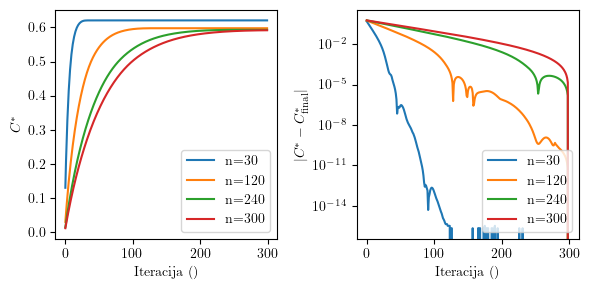

In [34]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(6,3))
for n_dim in [30, 120, 240, 300,]:
    nn, cc = evaluate(n_dim=n_dim)
    ax1.plot(nn, cc, label=f"n={n_dim}")
    ax1.set_ylabel(r"$C^{*}$")
    ax1.set_xlabel("Iteracija ()")
    ax1.legend()
    ax2.plot(nn, np.abs(cc-cc[-1]), label=f"n={n_dim}")
    ax2.set_ylabel(r"$|C^{*} - C^{*}_{\mathrm{final}}|$")
    ax2.set_yscale("log")
    ax2.set_xlabel("Iteracija ()")
    ax2.legend()
plt.tight_layout()
plt.savefig("1-C__.pdf")

# Druga naloga

Implementiral bom vse od začetka.

/tmp/ipykernel_497411/3015775291.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


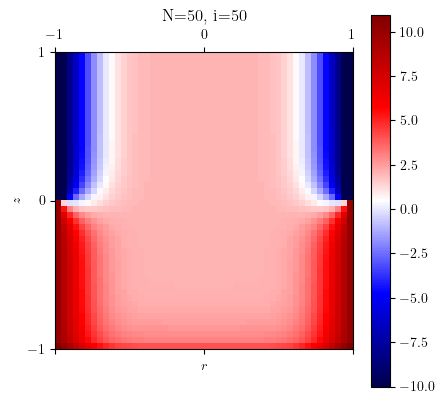

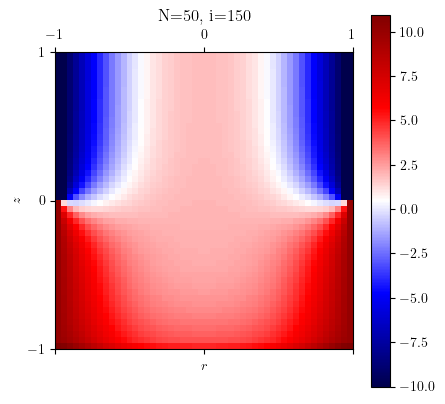

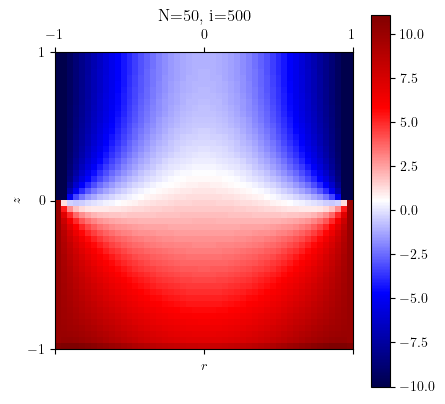

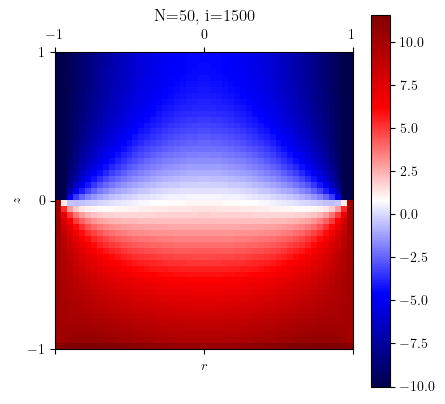

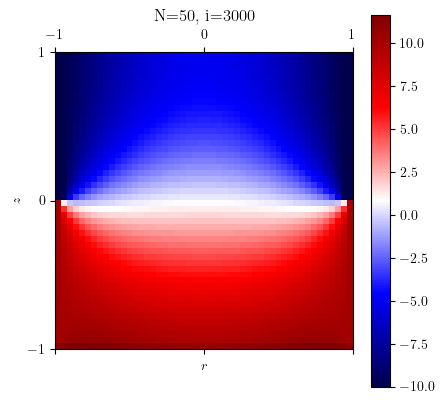

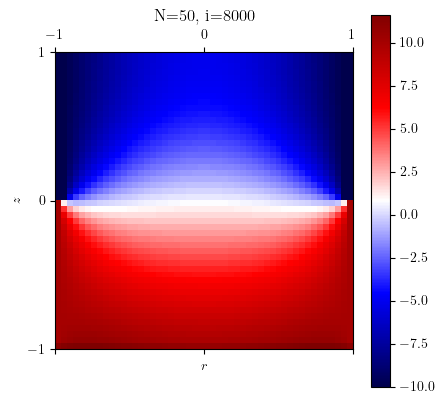

In [55]:
N = 50
h = 1/N
rs = np.arange(-1, 1, h) + h/2
zs = np.arange(-1,1,h)
T1 = -10
T2 = 10
k = 15

# import pdb
# @jit
# def ibc(u, T1, T2, k):
#     """Imposes boundary conditions on u."""
#     N_z, N_r = u.shape
#     u[0:N_z//2, 0] = u[0:N_z//2, -1] = T1
#     u[N_z//2:, 0] = u[N_z//2:, -1] = T2

#     u[0, :] = u[1, :]

#     u[-1, :]  = u[-2, :] + k / N_z

#     return u
# @jit
# def iterate(u, rs, T1, T2, k):
#     u = ibc(u, T1, T2, k)
#     u_new = u.copy()
#     N_z, N_r = u.shape
#     for k in range(1,N_r-1):
#         for j in range(1, N_z-1):
#             u_new[j,k] = u[j,k] + (1/4/rs[j])*(-4*rs[j] * u[j,k] + rs[j] * (u[j,k-1] + u[j, k+1]) + u[j-1,k] * rs[j] + u[j+1, k] * rs[j])
#     u_new = ibc(u_new, T1, T2, k)

#     return u_new

# u_initial = np.full((N, N), 2, dtype=float)
# u = ibc(u_initial, T1, T2,k)
# for i in range(8001):
#     u = iterate(u, rs, T1, T2, k)
#     if i in {50, 150, 500, 1500, 3000, 8000}:
#         plt.matshow(u, cmap="seismic", extent=[-1,1,-1,1])
#         #plt.contourf(u[-1:0:-1, :], cmap="seismic")
#         plt.title(f"N={N}, i={i}")
#         plt.ylabel(r"$z$")
#         plt.xlabel("$r$")
#         plt.colorbar()
#         plt.tight_layout()
#         plt.savefig(f"2-valj-profili{N}_{i}.pdf")
#         plt.show()



import pdb
@jit
def ibc(u, T1, T2, k, iso=False):
    """Imposes boundary conditions on u."""
    N_z, N_r = u.shape
    u[0, :] = T1
    u[0:N_z//2, 0] = u[0:N_z//2, -1] = T1
    u[N_z//2:, 0] = u[N_z//2:, -1] = T2
    u[0, :] = u[1, :]
    u[-1, :]  = u[-2, :] + k / N_z
    if iso:
        u[:N_z//2, -2] = u[:N_z//2, -1]
        u[:N_z//2, 1] = u[:N_z//2, 0]
    return u
@jit
def iterate(u, rs, T1, T2, k, iso=False):
    u = ibc(u, T1, T2, k, iso=iso)
    u_new = u.copy()
    N_z, N_r = u.shape
    for k in range(1,N_r-1):
        for j in range(1, N_z-1):
            u_new[j,k] = u[j,k] + (1/4/rs[j])*(-4*rs[j] * u[j,k] + rs[j] * (u[j,k-1] + u[j, k+1]) + u[j-1,k] * rs[j] + u[j+1, k] * rs[j])
    u_new = ibc(u_new, T1, T2, k, iso=iso)

    return u_new

u_initial = np.full((N, N), 2, dtype=float)
u = ibc(u_initial, T1, T2,k, iso=True)
# plt.matshow(u)
for i in range(8001):
    u = iterate(u, rs, T1, T2, k, iso=True)
    if i in {50, 150, 500, 1500, 3000, 8000}:
        plt.matshow(u, cmap="seismic", extent=[-1,1,-1,1])
        #plt.contourf(u[-1:0:-1, :], cmap="seismic")
        plt.title(f"N={N}, i={i}")
        plt.ylabel(r"$z$")
        plt.xlabel("$r$")
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(f"2-valj-profili{N}_{i}_iso.pdf")
        plt.show()

In [52]:
u[0, :]

array([-10.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2., -10.])

## Implementacija SOR za valj

In [ ]:
N = 50
h = 1/N
rs = np.arange(-1, 1, h) + h/2
zs = np.arange(-1,1,h)
T1 = -10
T2 = 10
k = 15

import pdb
@jit
def ibc(u, T1, T2, k):
    """Imposes boundary conditions on u."""
    N_z, N_r = u.shape
    u[0:N_z//2, 0] = u[0:N_z//2, -1] = T1
    u[N_z//2:, 0] = u[N_z//2:, -1] = T2

    u[0, :] = u[1, :]

    u[-1, :]  = u[-2, :] + k / N_z

    return u
@jit
def iterate(u, rs, T1, T2, k):
    u = ibc(u, T1, T2, k)
    u_new = u.copy()
    N_z, N_r = u.shape
    for k in range(1,N_r-1):
        for j in range(1, N_z-1):
            u_new[j,k] = u[j,k] + (1/4/rs[j])*(-4*rs[j] * u[j,k] + rs[j] * (u[j,k-1] + u[j, k+1]) + u[j-1,k] * rs[j] + u[j+1, k] * rs[j])
    u_new = ibc(u_new, T1, T2, k)

    return u_new
@jit
def iterate_SOR(u, rs, T1, T2, k, a):
    u = ibc(u, T1, T2, k)
    u_star = u.copy()
    N_z, N_r = u.shape
    omega = 2/(1 + a * np.pi/N_r)
    for k in range(1,N_r-1):
        for j in range(1, N_z-1):
            u_star[j,k] = u[j,k] + (1/4/rs[j])*(-4*rs[j] * u[j,k] + rs[j] * (u[j,k-1] + u[j, k+1]) + u[j-1,k] * rs[j] + u[j+1, k] * rs[j])
    u_new = u + omega * (u_star - u)
    return u_new

def err(a1, a2):
    return np.abs(np.sum(a1-a2))


aas = np.linspace(14, 16, 100)
difs = np.empty_like(aas, dtype=float)

u_final = np.full((N, N), 10, dtype=float)
for i in range(1000):
    u_final = ibc(u_final, T1, T2, k)
    u_final = iterate(u_final, rs, T1, T2, k)

for i, a in enumerate(aas):
    print(i, end="\r")
    u = np.full((N, N), 10, dtype=float)
    for _ in range(500):
        u = iterate_SOR(u, rs, T1, T2, k, a)
    difs[i] = err(u, u_final)

plt.plot(aas, difs)
plt.semilogy()
plt.show()

In [ ]:
plt.plot(aas, difs)
plt.semilogy()
plt.ylabel(r"log error")
plt.xlabel(r"$\alpha$")
plt.savefig("2-errors.pdf")
plt.show()

In [ ]:
N = 500
u = np.full((N, N), 0, dtype=float)
a = 2
for _ in range(6000):
    u = iterate_SOR(u, rs, T1, T2, k, a)
plt.matshow(u, cmap="seismic", extent=[-1,1,-1,1])
plt.title(f"N={N}, i={i}")
plt.ylabel(r"$z$")
plt.xlabel("$r$")
plt.colorbar()
plt.tight_layout()
#plt.savefig(f"2-valj-SOR.pdf")
plt.show()


In [ ]:

plt.matshow(u, cmap="seismic", extent=[-1,1,-1,1])
plt.title(f"N={N}, i={8000}")
plt.ylabel(r"$z$")
plt.xlabel("$r$")
plt.colorbar()
plt.tight_layout()
#plt.savefig(f"2-valj-SOR.pdf")
plt.show()

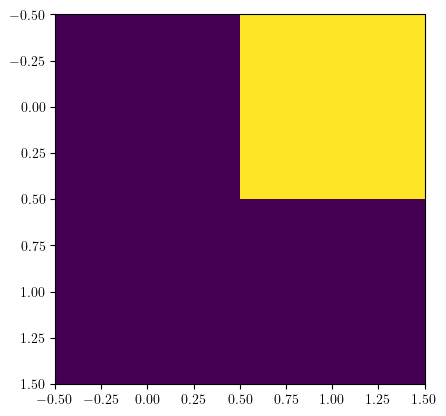

In [48]:
plt.imshow([
    [0,1],
    [0,0]
])